# **Modelling and Evaluation Notebook**

## Objectives

* Fulfill Business Requirements 2 - predict if a cherry leaf is healthy or contains powdery mildew.

## Inputs

* inputs/cherry_leaves_dataset/cherry_leaves/train
* inputs/cherry_leaves_dataset/cherry_leaves/validation
* inputs/cherry_leaves_dataset/cherry_leaves/test

## Outputs

* Image Augmentation.
* Image distribution plot, train vs validation vs test.
* Machine learning model creation and training.
* Plotting model performance.
* Prediction of a selected image file.



---

# Set Working Directory

In [2]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/cherry-leaves-mildew-detection/jupyter_notebooks'

In [3]:
os.chdir("/workspace/cherry-leaves-mildew-detection")
print("You set a new current directory")

You set a new current directory


In [4]:
current_dir = os.getcwd()
current_dir

'/workspace/cherry-leaves-mildew-detection'

### Set Input Directories

In [5]:
data_dir = "inputs/cherry_leaves_dataset/cherry_leaves"
train_dir = data_dir + "/train"
val_dir = data_dir + "/validation"
test_dir = data_dir + "/test"

### Set Output Directory

In [6]:
version = "v2"
file_path = f"outputs/{version}"
if "outputs" in os.listdir(current_dir) and version in os.listdir(current_dir + "/outputs"):
    print("This directory exists, create a new version.")
else:
    os.makedirs(name=file_path)

### Set Label Names

In [7]:
labels = os.listdir(train_dir)
print("The image labels are", labels)

The image labels are ['healthy', 'powdery_mildew']


---

# Import Image Shape

In [8]:
import joblib

image_shape = joblib.load(filename=f"outputs/v1/image_shape_embed.pkl")
image_shape

(256, 256, 3)

---

# Label Frequency Per Set

### Image Distribution Per Label Per Set

/tmp/ipykernel_1266/3204433454.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_label_frequency = df_label_frequency.append(pd.Series(data={"Dataset": set,
/tmp/ipykernel_1266/3204433454.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_label_frequency = df_label_frequency.append(pd.Series(data={"Dataset": set,
/tmp/ipykernel_1266/3204433454.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_label_frequency = df_label_frequency.append(pd.Series(data={"Dataset": set,
/tmp/ipykernel_1266/3204433454.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_label_frequency = df_label_frequency.append(pd.Series(data={"Dataset

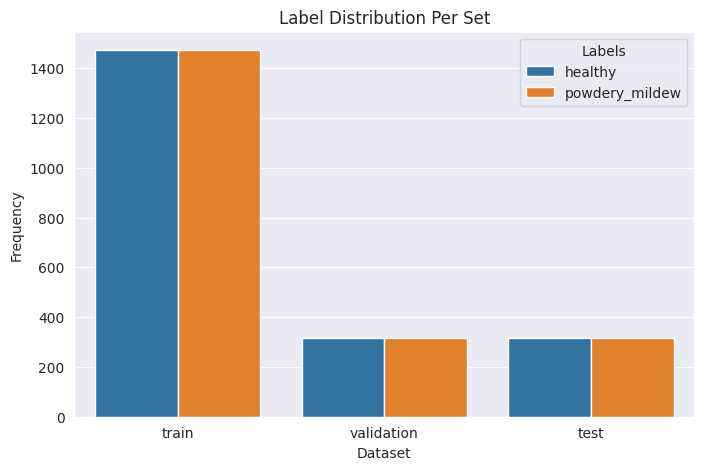

In [9]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

df_label_frequency = pd.DataFrame([])
for set in ["train", "validation", "test"]:
    for label in labels:
        count = int(len(os.listdir(data_dir + "/" + set + "/" + label)))
        df_label_frequency = df_label_frequency.append(pd.Series(data={"Dataset": set, 
                                                                       "Labels": label,
                                                                       "Frequency": count}),
                                                        ignore_index=True)

sns.set_style("darkgrid")
plt.figure(figsize=(8, 5))
sns.barplot(data=df_label_frequency, x="Dataset", y="Frequency", hue="Labels")
plt.title("Label Distribution Per Set")
if "label_distribution_graph.png" not in file_path:
    plt.savefig(f"{file_path}/label_distribution_graph.png")
else:
    plt.show()

The data is distrubted between the set in a 70:15:15 split. There are an equal number of healthy and powdery images so the dataset is balanced.

---

# Section 2

Section 2 content

---

NOTE

* You may add as many sections as you want, as long as it supports your project workflow.
* All notebook's cells should be run top-down (you can't create a dynamic wherein a given point you need to go back to a previous cell to execute some task, like go back to a previous cell and refresh a variable content)

---

# Push files to Repo

* If you don't need to push files to Repo, you may replace this section with "Conclusions and Next Steps" and state your conclusions and next steps.

In [ ]:
import os
try:
    # create here your folder
    # os.makedirs(name='')
except Exception as e:
    print(e)
